# InfoGAN结构
<!---![20200211202257.png](https://image.zkhweb.top/20200211202257.png)--->
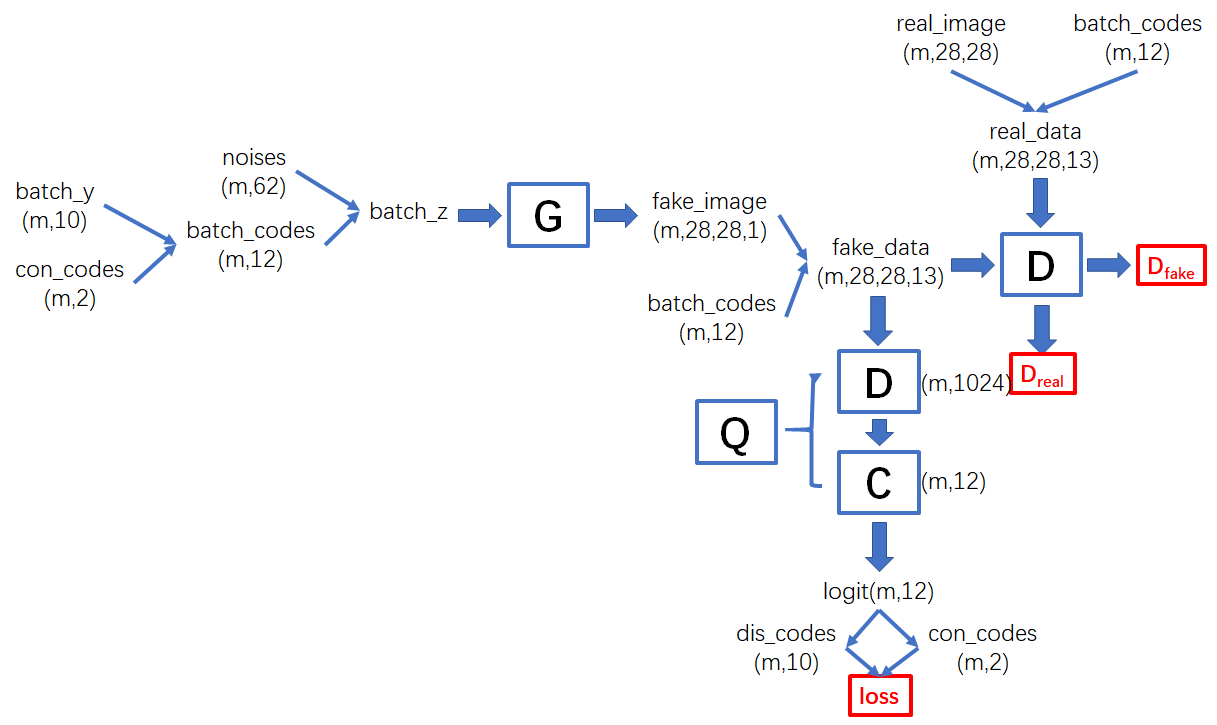

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

tf.random.set_seed(22)
np.random.seed(22)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
assert tf.__version__.startswith('2.')

In [ ]:
# 参数设置
batchsz = 64
z_dim = 62
y_dim = 12
len_discrete_code = 10
len_continuous_code = 2
learning_rate = 2e-4
is_training = True
epochs = 30000
sample_count = 10
network_path = "E:\\C_all\\Desktop\\深度之眼\\paper\\tensorflow\\文献实现\\GAN\\模型输出\\InfoGAN\\"
img_path = "E:\\C_all\\Desktop\\深度之眼\\paper\\tensorflow\\文献实现\\GAN\\out\\"
if not os.path.exists(img_path):
    os.makedirs(img_path)

In [ ]:
gs = gridspec.GridSpec(2, 2)
ax = plt.subplot(gs[0, 0])

In [ ]:
# 该函数用于输出生成图片
def plot(samples, sample_count=sample_count):
    fig = plt.figure(figsize=(sample_count, sample_count))
    gs = gridspec.GridSpec(sample_count, sample_count)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(tf.reshape(sample*255.,(28, 28)), cmap='Greys_r')

    return fig

In [ ]:
class Generator(keras.Model):
    def __init__(self):
        super(Generator, self).__init__(name='generator')
        self.bn_1 = keras.layers.BatchNormalization(epsilon=1e-5,momentum=0.9,scale=True)
        self.bn_2 = keras.layers.BatchNormalization(epsilon=1e-5,momentum=0.9,scale=True)
        self.bn_3 = keras.layers.BatchNormalization(epsilon=1e-5,momentum=0.9,scale=True)
        self.fc_1 = keras.layers.Dense(1024)
        self.fc_2 = keras.layers.Dense(128*7*7)
        self.conv_1 = keras.layers.Conv2DTranspose(64, 4, 2, padding='same')
        self.conv_2 = keras.layers.Conv2DTranspose(1, 4, 2, padding='same')
    def call(self, inputs, training=None):
        g_1 = self.bn_1(self.fc_1(inputs))
        g_1 = tf.nn.relu(g_1)
        g_2 = self.bn_2(self.fc_2(g_1))
        g_3 = tf.reshape(tf.nn.relu(g_2),(-1,7,7,128))
        g_4 = self.bn_3(self.conv_1(g_3))
        g_5 = tf.nn.relu(g_4)
        g_6 = tf.nn.sigmoid(self.conv_2(g_5))
        return g_6


class Discriminator(keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__(name='discriminator')
        self.conv_1 = keras.layers.Conv2D(64, 4, 2,padding='same')
        self.conv_2 = keras.layers.Conv2D(128, 4, 2,padding='same')
        self.bn_1 = keras.layers.BatchNormalization(epsilon=1e-5,momentum=0.9,scale=True)
        self.bn_2 = keras.layers.BatchNormalization(epsilon=1e-5,momentum=0.9,scale=True)
        self.fc_1 = keras.layers.Dense(1024)
        self.fc_2 = keras.layers.Dense(1)
    def call(self, inputs, training=None):
        d_1 = tf.nn.leaky_relu(self.conv_1(inputs))
        d_2 = self.bn_1(self.conv_2(d_1))
        d_3 = tf.nn.leaky_relu(d_2)
        d_4 = keras.layers.Flatten()(d_3)
        d_5 = self.bn_2(self.fc_1(d_4))
        d_6 = tf.nn.leaky_relu(d_5)
        out_logits = self.fc_2(d_6)
        out = tf.nn.sigmoid(out_logits)
        return out, out_logits, d_6


class Classifier(keras.Model):
    def __init__(self, y_dim):
        super(Classifier, self).__init__(name="classifier")
        self.y_dim = y_dim
        self.bn_1 = keras.layers.BatchNormalization(epsilon=1e-5,momentum=0.9,scale=True)
        self.fc_1 = keras.layers.Dense(64)
        self.fc_2 = keras.layers.Dense(self.y_dim)
    def call(self, inputs, training=None):
        c_1 = self.bn_1(self.fc_1(inputs))
        c_2 = keras.layers.LeakyReLU(alpha=0.2)(c_1)
        out_logits = self.fc_2(c_2)
        out = tf.nn.softmax(out_logits)
        return out, out_logits

In [ ]:
def sample_z(m=batchsz, n=z_dim):
    return tf.random.uniform(maxval=1., minval=-1., shape=[m, n])

In [ ]:
def conv_cond_concat(x, y):
    x_shapes = tf.shape(x)
    y_shapes = tf.shape(y)
    y = tf.reshape(y, [-1, 1, 1, y_shapes[1]])
    y_shapes = tf.shape(y)
    return tf.concat([x, y*tf.ones([x_shapes[0], x_shapes[1], x_shapes[2], y_shapes[3]])], 3)

In [ ]:
(x, y),(x_val,y_val) = keras.datasets.mnist.load_data()

x = tf.convert_to_tensor(x, dtype=tf.float32)/255.
x = tf.reshape(x,(-1, 28,28,1))
y = tf.convert_to_tensor(y, dtype=tf.int32)
y_onehot = tf.one_hot(y, depth=10) # one_hot成立
train_dataset = tf.data.Dataset.from_tensor_slices((x,y_onehot)).repeat(-1).batch(batchsz)
train_dbiter = iter(train_dataset)

In [ ]:
generator = Generator()
# generator.build(input_shape=(None, z_dim))
discriminator = Discriminator()
# discriminator.build(input_shape=(None, 784))
classifier = Classifier(y_dim)
# classifier.build

g_optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
d_optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
c_optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

In [ ]:
# 交叉熵损失函数
def celoss_ones(logits):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=tf.ones_like(logits))
    return tf.reduce_mean(loss)


def celoss_zeros(logits):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=tf.zeros_like(logits))
    return tf.reduce_mean(loss)

def d_loss_fn(generator, discriminator, classifier, batch_z, batch_x, batch_codes, is_training):
    fake_data = generator(batch_z, is_training)
    fake_data = conv_cond_concat(fake_data, batch_codes)
    real_images = conv_cond_concat(batch_x, batch_codes)
    d_real,d_real_logits,_ = discriminator(real_images, is_training)
    d_fake,d_fake_logits,input4classifier_fake = discriminator(fake_data, is_training)
    d_loss_real = celoss_ones(d_real_logits)
    d_loss_fake = celoss_zeros(d_fake_logits)
    d_loss = d_loss_fake + d_loss_real
    return d_loss
def g_loss_fn(generator, discriminator, classifier, batch_z, batch_codes, is_training):
    fake_data = generator(batch_z, is_training)
    fake_data = conv_cond_concat(fake_data, batch_codes)
    d_fake,d_fake_logits,_ = discriminator(fake_data, is_training)
    g_loss = celoss_ones(d_fake_logits)
    return g_loss
def q_loss_fn(generator, discriminator, classifier, batch_z, batch_codes, is_training):
    fake_data = generator(batch_z, is_training)
    fake_data = conv_cond_concat(fake_data, batch_codes)
    d_fake,d_fake_logits,input4classifier_fake = discriminator(fake_data, is_training)
    code_fake, code_logit_fake = classifier(input4classifier_fake, is_training)
    disc_code_est = code_logit_fake[:, :len_discrete_code]
    disc_code_tg = batch_codes[:, :len_discrete_code]
    cont_code_est = code_logit_fake[:, len_discrete_code:]
    cont_code_tg = batch_codes[:, len_discrete_code:]
    q_disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=disc_code_tg, logits=disc_code_est))
    q_cont_loss = tf.reduce_mean(tf.reduce_sum(tf.square(cont_code_tg - cont_code_est), axis=1))
    q_loss = q_disc_loss+q_cont_loss
    return q_loss

In [80]:
def save_batch_codes(m=sample_count**2, n=z_dim):
#     tf.random.uniform(maxval=1., minval=-1., shape=[m, n])
#     noise = sample_z(m=m, n=z_dim)
    noise = tf.constant(0.5, dtype=tf.float32, shape=(100,z_dim)) 
    c1 = tf.reshape(tf.convert_to_tensor(np.linspace(-10,10,10)),(10, 1))
    c1 = tf.cast(tf.reshape(np.tile(c1,10),(100,1)),dtype=tf.float32)
    c2 = tf.constant(1, dtype=tf.float32, shape=(1,10)) 
    c2 = tf.reshape(np.tile(c2,10),(100,1))
    sample_y = tf.one_hot(list(range(10)) * 10,depth=10,dtype=tf.float32)
    batch_z_1 = tf.concat([noise, sample_y, c1, c2],axis=1)
    batch_z_2 = tf.concat([noise, sample_y, c2, c1],axis=1)
    return batch_z_1, batch_z_2

In [78]:
def save_image(label, generator, m=sample_count**2, n=z_dim):
    batch_z_1, batch_z_2 = save_batch_codes(m=m, n=z_dim)
    fake_images_1 = generator(batch_z_1)
    fake_images_2 = generator(batch_z_2)
    fig = plot(fake_images_1)
    plt.savefig(img_path + "{}_c1.png".format(label),bbox_inches="tight")
    plt.close(fig)
    fig = plot(fake_images_2)
    plt.savefig(img_path + "{}_c2.png".format(label),bbox_inches="tight")
    plt.close(fig)

In [ ]:
def save_weights_(generator, discriminator, classifier, network_path=network_path):
    if not os.path.exists(img_path):
        os.makedirs(img_path)
    generator.save_weights(network_path+"infogan_g")
    discriminator.save_weights(network_path+"infogan_d")
    classifier.save_weights(network_path+"infogan_c")
    print("saved total weights.")

In [ ]:
for epoch in range(epochs+1):
    batch_x, batch_y = next(train_dbiter)
    noises = sample_z()
    codes = sample_z(n=len_continuous_code)
    batch_codes = tf.concat((batch_y, codes), axis=1)
    batch_z = tf.concat([noises, batch_codes], 1)
    
    with tf.GradientTape() as tape:
        d_loss = d_loss_fn(generator, discriminator, classifier, batch_z, batch_x, batch_codes, is_training)
    grads = tape.gradient(d_loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    with tf.GradientTape() as tape:
        g_loss = g_loss_fn(generator, discriminator, classifier, batch_z, batch_codes, is_training)
    grads = tape.gradient(g_loss, generator.trainable_variables)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    with tf.GradientTape() as tape:
        c_loss = q_loss_fn(generator, discriminator, classifier, batch_z, batch_codes, is_training)
    grads = tape.gradient(c_loss, classifier.trainable_variables)
    c_optimizer.apply_gradients(zip(grads, classifier.trainable_variables))
    
    if epoch % 1000 == 0:
        save_weights_(generator, discriminator, classifier)
        save_image(str(epoch), generator)
        print(epoch, 'd-loss:', float(d_loss), 'g-loss:', float(g_loss), 'c-loss:', float(c_loss))
        print()

In [81]:
# # # 在custom layer中的 call() 上添加 @tf.function 可以将前向传播过程中不属于Graph的部分 转化为Graph。
# # network_path = "E:\\C_all\\Desktop\\深度之眼\\paper\\tensorflow\\文献实现\\GAN\\模型输出\\"
# # generator.save_weights(network_path+"original_gan_g")
# # discriminator.save_weights(network_path+"original_gan_d")
# # print("saved total weights.")
del generator
del discriminator
del classifier
generator = Generator()
discriminator = Discriminator()
classifier = Classifier(y_dim)
save_image("载入前",generator)
generator.load_weights(network_path+"infogan_g")
discriminator.load_weights(network_path+"infogan_d")
classifier.load_weights(network_path+"infogan_c")
save_image("载入后",generator)

W0211 22:45:34.540309 13020 util.py:144] Unresolved object in checkpoint: (root).conv_1.kernel
W0211 22:45:34.547290 13020 util.py:144] Unresolved object in checkpoint: (root).conv_1.bias
W0211 22:45:34.550282 13020 util.py:144] Unresolved object in checkpoint: (root).conv_2.kernel
W0211 22:45:34.552277 13020 util.py:144] Unresolved object in checkpoint: (root).conv_2.bias
W0211 22:45:34.555271 13020 util.py:144] Unresolved object in checkpoint: (root).bn_1.axis
W0211 22:45:34.556269 13020 util.py:144] Unresolved object in checkpoint: (root).bn_1.gamma
W0211 22:45:34.558262 13020 util.py:144] Unresolved object in checkpoint: (root).bn_1.beta
W0211 22:45:34.562259 13020 util.py:144] Unresolved object in checkpoint: (root).bn_1.moving_mean
W0211 22:45:34.566241 13020 util.py:144] Unresolved object in checkpoint: (root).bn_1.moving_variance
W0211 22:45:34.568234 13020 util.py:144] Unresolved object in checkpoint: (root).bn_2.axis
W0211 22:45:34.570230 13020 util.py:144] Unresolved object 

In [ ]:
sample_z = tf.random.uniform(minval=-1, maxval=1, shape=(100, z_dim),dtype=tf.dtypes.float32)
sample_label=tf.cast(2*(tf.ones(shape=(100,),dtype=tf.int32)),dtype=tf.int32)
sample_label=tf.one_hot(sample_label,depth=10)
continuous_code=tf.random.uniform(shape=[100, len_continuous_code],minval=-1.0,maxval=1.0,dtype=tf.dtypes.float32)
test_codes = tf.concat([sample_label,continuous_code],1)
a = tf.concat([sample_z, test_codes[:100, :]], 1)

In [75]:
a

<tf.Tensor: id=48378, shape=(100, 74), dtype=float32, numpy=
array([[ 0.18566608, -0.0535264 ,  0.7227545 , ...,  0.        ,
        -0.36855316, -0.29288173],
       [-0.21760821,  0.67255735, -0.7642422 , ...,  0.        ,
         0.14891362,  0.56608605],
       [ 0.6677983 ,  0.6725352 ,  0.44026232, ...,  0.        ,
         0.8780787 ,  0.38615608],
       ...,
       [-0.02205992,  0.9639349 , -0.79141283, ...,  0.        ,
        -0.8850534 ,  0.34556556],
       [-0.2933631 , -0.4906981 , -0.87551355, ...,  0.        ,
        -0.81384563,  0.7296238 ],
       [ 0.21849751, -0.08593965,  0.25973225, ...,  0.        ,
        -0.99078894,  0.280766  ]], dtype=float32)>

In [ ]:
output_image = []
cc = np.linspace(-2.0, 2.0, 10)
z = tf.random.uniform(maxval=1., minval=-1., shape=[1, 62])
for i in range(5):
    imgs = []
    for ii in range(10):
        noise = sample(z, 1, c1=-1.0, c2=cc[ii])
        img = generator(noise, training=False)[0]
        img = (img + 1.) / 2.
        imgs.append(np.reshape(img, [28, 28]))
    imgs = np.concatenate(imgs, 1)
    output_image.append(imgs)
    
output_image = np.concatenate(output_image, 0)
output_image.shape

In [ ]:
def sample(size, cat=-1, c1=None, c2=None):
    z = tf.random.uniform(maxval=1., minval=-1., shape=[size, 1])
    
    if c1 is not None:
        z_con1 = np.array([c1] * size)
        z_con1 = np.reshape(z_con1, [size, 1])
    else:
        z_con1 = tf.random.uniform(maxval=1., minval=-1., shape=[size, 1])
        
    if c2 is not None:
        z_con2 = np.array([c2] * size)
        z_con2 = np.reshape(z_con2, [size, 1])
    else:
        z_con2 = tf.random.uniform(maxval=1., minval=-1., shape=[size, 1])
    if cat >= 0:
        z_cat = np.array([cat] * size)
        z_cat = tf.one_hot(z_cat, 10)
    else:
        pass
        z_cat = tfd.Categorical(probs=tf.ones([10])*0.1).sample([size,])
        z_cat = tf.one_hot(z_cat, 10)
    
    noise = tf.concat([z, z_con1, z_con2], axis=-1)
    
    return noise, z_con1, z_con2#, z_cat

In [ ]:
sample(z, 1, cat=0, c1=-1.0, c2=cc[ii])

In [83]:
from tensorflow_probability import distributions as tfd

ImportError: This version of TensorFlow Probability requires TensorFlow version >= 2.1; Detected an installation of version 2.0.0. Please upgrade TensorFlow to proceed.

In [84]:
tfd.Categorical

Object `tfd.Categorical` not found.
